# Using DeepAnT for unsupervised anomaly detection in time series

The DeepAnT algorithm is a neural network based algorithm that aims at detecting anomaly in time series (univariate or multivariate, it can theoretically work with both). 

While many algorithms have been proposed using Recurrent Neural Networks (RNN), the originality of this algorithm is that it leverages convolutions instead. 

In essence, the architecture of the neural network is quite simple as it consists of the following layers:
- a convolution layer
- a maxpool layer
- a convolution layer
- a maxpool layer
- a linear layer

Time series are sequenced into the network by using a sequence as inputs for training and a subsequent sequence as targets for training. 
This gives us a set of parameters to consider:
- the length of the sequence for inputs: we call it `window` in the code below
- the length of the sequence we want to predict: we call it `p_window` in the code below

More information can be found in the DeepAnT paper available at: https://www.dfki.de/fileadmin/user_upload/import/10175_DeepAnt.pdf

In [1]:
from keras import Sequential
import keras.metrics as metrics
import keras.layers as layers
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from typing import Tuple, List
import keras
from pathlib import Path
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

register_matplotlib_converters()
sns.set_style('darkgrid')
plt.rc('font',size=13)

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Dataset for use: Marotta MPV-41 series valve

To illustrate the algorithm, we are going to use the NASA Shuttle valve dataset which is available here: https://cs.fit.edu/~pkc/nasa/data/.

More specifically, we will use the `TEK000XX.CSV` files which are recordings of solenoid current measurements on a Marotta MPV-41 series valve. We will use the files from 0 to 3 for training and file 16 to illustrate an anomaly. Files 0 to 3 corresponds to normal behaviour of the valve while 16 corresponds to a forced movement in the valve poppet.

In [2]:
URL_SHUTTLE_VALVE = 'https://cs.fit.edu/~pkc/nasa/data/nasaValve.zip'
DATA_FILE = 'nasaValve.zip'
DATA_DIR = Path('Data')
DATA = DATA_DIR / DATA_FILE
DATA_SHUTTLE = Path(DATA_DIR / 'Shuttle')

if not Path(DATA_DIR).exists():
    DATA_DIR.mkdir()
    
if not Path(DATA_SHUTTLE).exists():
    DATA_SHUTTLE.mkdir()
    
def get_shuttle_data(data_path: Path, url: str) -> None:
    if not Path(data_path).is_file():
        data = requests.get(url, stream=True)
        data.raise_for_status()
        
        with open(data_path, 'wb') as f:
            f.write(data.raw.read())

In [3]:
def prepare_data(data_path: Path, data_dir: Path) -> List[str]:
    with zipfile.ZipFile(data_path, 'r') as f:
        list_of_files = f.namelist()
        f.extractall(data_dir)
    
    return list_of_files

get_shuttle_data(DATA, URL_SHUTTLE_VALVE)
files = prepare_data(DATA, DATA_SHUTTLE)
FILE_DIR = DATA_SHUTTLE / 'Waveform Data' / 'COL 1 Time COL 2 Current'

for i, f in enumerate(files):
    print(f)
    if i > 10:
        break

README  Data File Formats.doc
Waveform Data/COL 1 Shunt COL 2 Temperature COL 3 Hall Effect Sensor/
Waveform Data/COL 1 Shunt COL 2 Temperature COL 3 Hall Effect Sensor/Data Set 1/
Waveform Data/COL 1 Shunt COL 2 Temperature COL 3 Hall Effect Sensor/Data Set 1/v37891 S000.TXT
Waveform Data/COL 1 Shunt COL 2 Temperature COL 3 Hall Effect Sensor/Data Set 1/v37891 S001.TXT
Waveform Data/COL 1 Shunt COL 2 Temperature COL 3 Hall Effect Sensor/Data Set 1/v37891 S001A.TXT
Waveform Data/COL 1 Shunt COL 2 Temperature COL 3 Hall Effect Sensor/Data Set 1/v37891 S002.TXT
Waveform Data/COL 1 Shunt COL 2 Temperature COL 3 Hall Effect Sensor/Data Set 1/v37891 S002A.TXT
Waveform Data/COL 1 Shunt COL 2 Temperature COL 3 Hall Effect Sensor/Data Set 1/v37891 S003.TXT
Waveform Data/COL 1 Shunt COL 2 Temperature COL 3 Hall Effect Sensor/Data Set 1/v37891 S003A.TXT
Waveform Data/COL 1 Shunt COL 2 Temperature COL 3 Hall Effect Sensor/Data Set 1/v37891 S004.TXT
Waveform Data/COL 1 Shunt COL 2 Temperature COL 

In [4]:
training_files = [FILE_DIR / 'TEK00000.CSV', 
                  FILE_DIR / 'TEK00001.CSV', 
                  FILE_DIR / 'TEK00002.CSV', 
                  FILE_DIR / 'TEK00003.CSV']

testing_files = [FILE_DIR / 'TEK00016.CSV']

## Plotting the current for a normal behaviour

Let's plot a normal event on the valve. We'll use the data from `TEK00002.CSV` for this purpose

In [5]:
columns = ['timestamp', 'current']
data = pd.read_csv(training_files[3], header=None, names=columns)

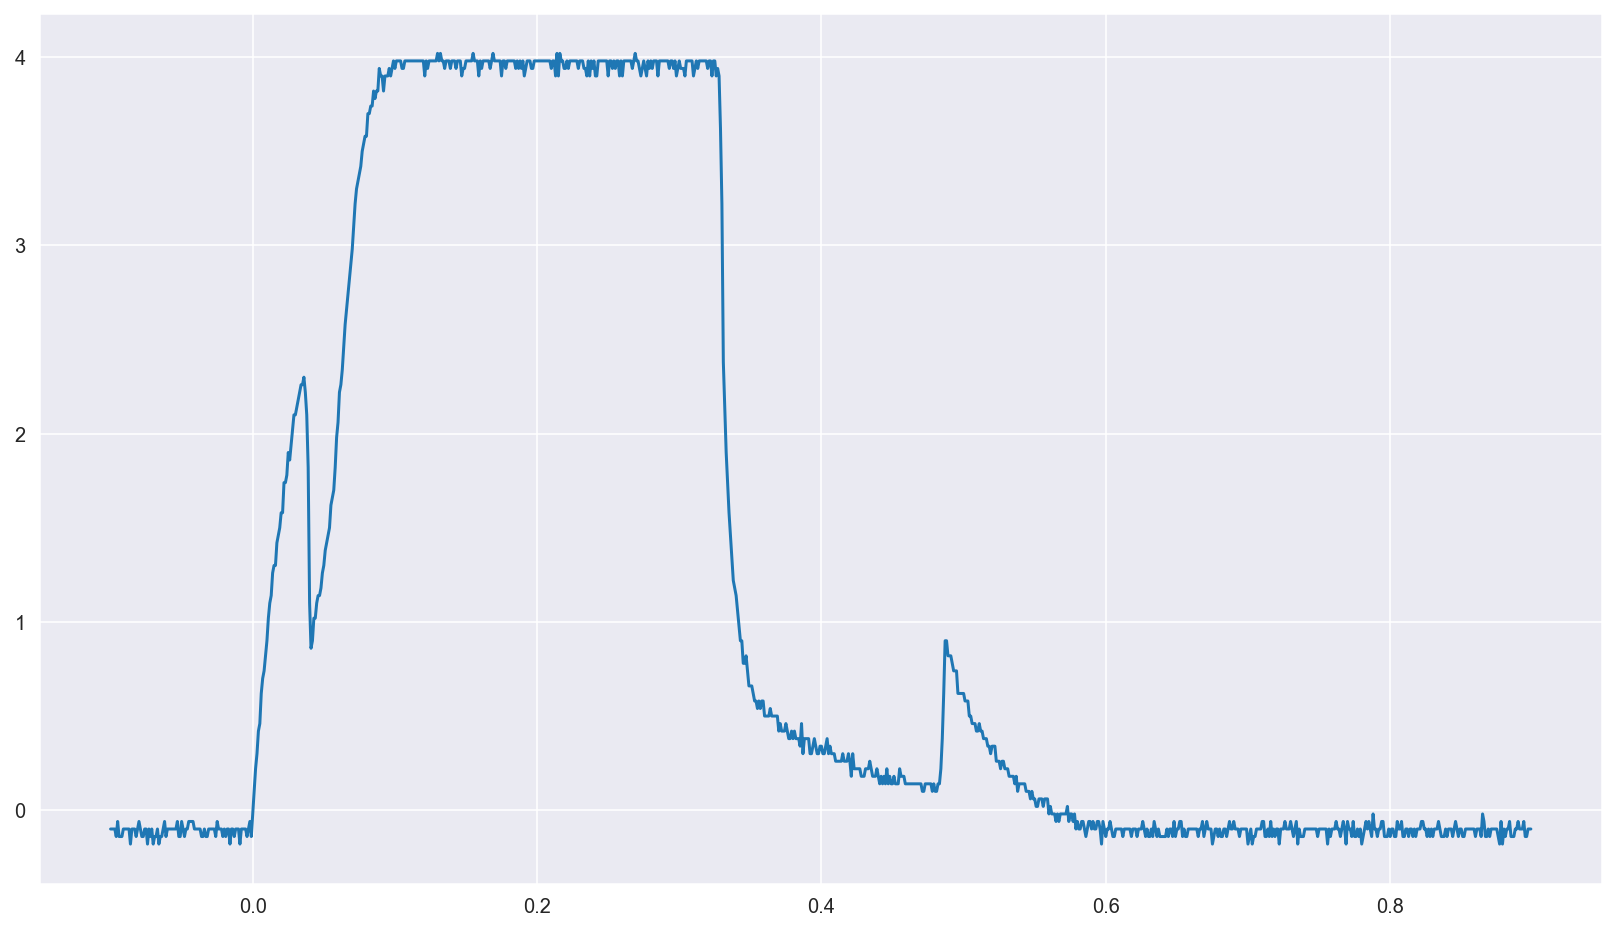

In [6]:
plt.figure(figsize=(14,8))
plt.plot(data['timestamp'], data['current'])

In [7]:
data.head()

,timestamp,current
0,-0.099943,-0.10
1,-0.098943,-0.10
2,-0.097943,-0.10
3,-0.096943,-0.10
4,-0.095943,-0.14


## Plotting the current for an abnormal behaviour

Now let's see what an abnormal event looks like using the data in file `TEK00016.CSV`. 

In [8]:
data_abn = pd.read_csv(testing_files[0], header=None, names=columns)

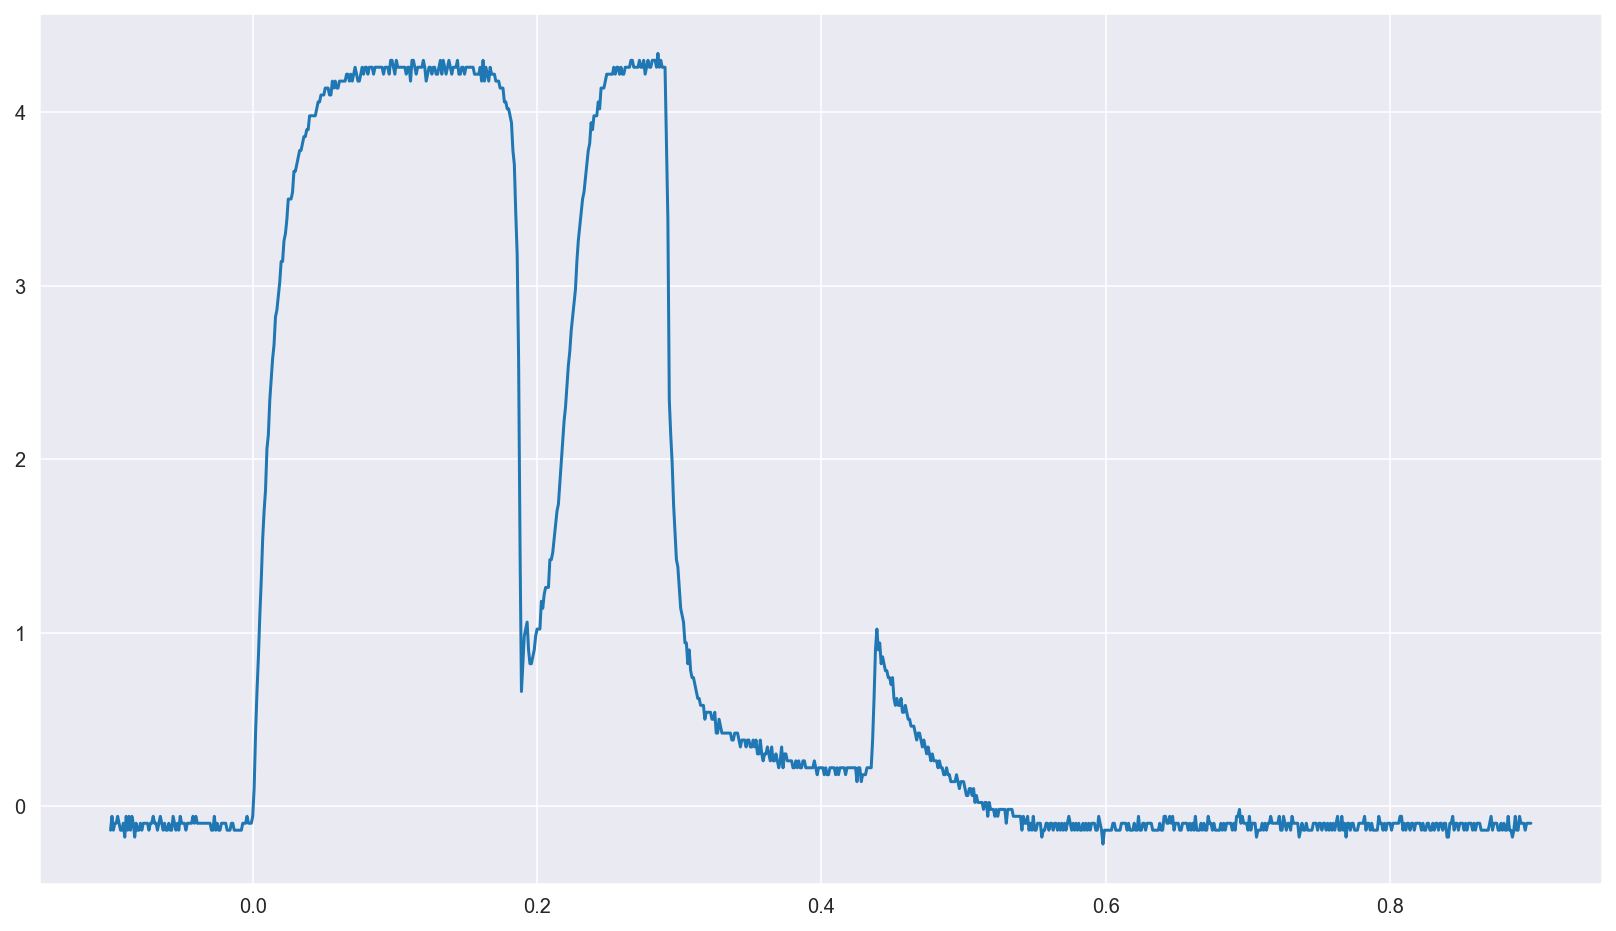

In [9]:
plt.figure(figsize=(14,8))
plt.plot(data_abn['timestamp'], data_abn['current'])

As we can see on the chart above, it doesn't take a neural network to spot the anomaly :-). 

## Creating the DeepAnT model

We are now going to create a function that will return a DeepAnT model using the `Keras` library. 

In [10]:
def create_model(window: int = 25, p_window: int = 1, nb_filters: int = 32, kernel_conv_size: int = 3,
                     kernel_pool_size: int = 2, input_dim: int = 1) -> Sequential:
    model = Sequential()

    model.add(layers.Conv1D(nb_filters, kernel_conv_size, activation='relu', input_shape=(window, input_dim)))
    model.add(layers.MaxPool1D(pool_size=kernel_pool_size, padding="valid"))

    model.add(layers.Conv1D(nb_filters, kernel_conv_size, activation='relu'))
    model.add(layers.MaxPool1D(pool_size=kernel_pool_size, padding="valid"))
    
    model.add(layers.Flatten())

    model.add(layers.Dense(p_window * input_dim))

    return model

This function has several inputs:
- `window`: the size of the sliding window we will apply on the valve data that we will use to create the dataset. It specifies how many timesteps we will use for our prediction. The DeepAnT paper recommends 25, 35 and 45 for window sizes, but this setting is domain specific.
- `p_window`: the size of the prediction window, i.e. the number of steps we want to predict in the future. 
- `nb_filters`: the number of filters we what to use in our convolutions. The DeepAnT paper specifies 32 filters.
- `kernel_conv_size`: the size of the kernels for our convolution layers
- `kernel_pool_size`: the size of the kernals for our maxpool layers
- `input_dim`: the number of dimensions for our time series

We now need to create our training dataset using the data from the four files we specified above. Our testing dataset (which is the one with the anomaly) also needs to be created. 

In [11]:
def build_dataset(file_list: List[Path]) -> np.ndarray:
    data = pd.DataFrame(columns=['timestamp','current'])
    for file in file_list:
        df = pd.read_csv(file, header=None, names=['timestamp', 'current'])
        data = pd.concat([data, df], sort=False)
            
    return data

In [12]:
train_ds = build_dataset(training_files)

In [13]:
train_ds.shape, type(train_ds)

((4000, 2), pandas.core.frame.DataFrame)

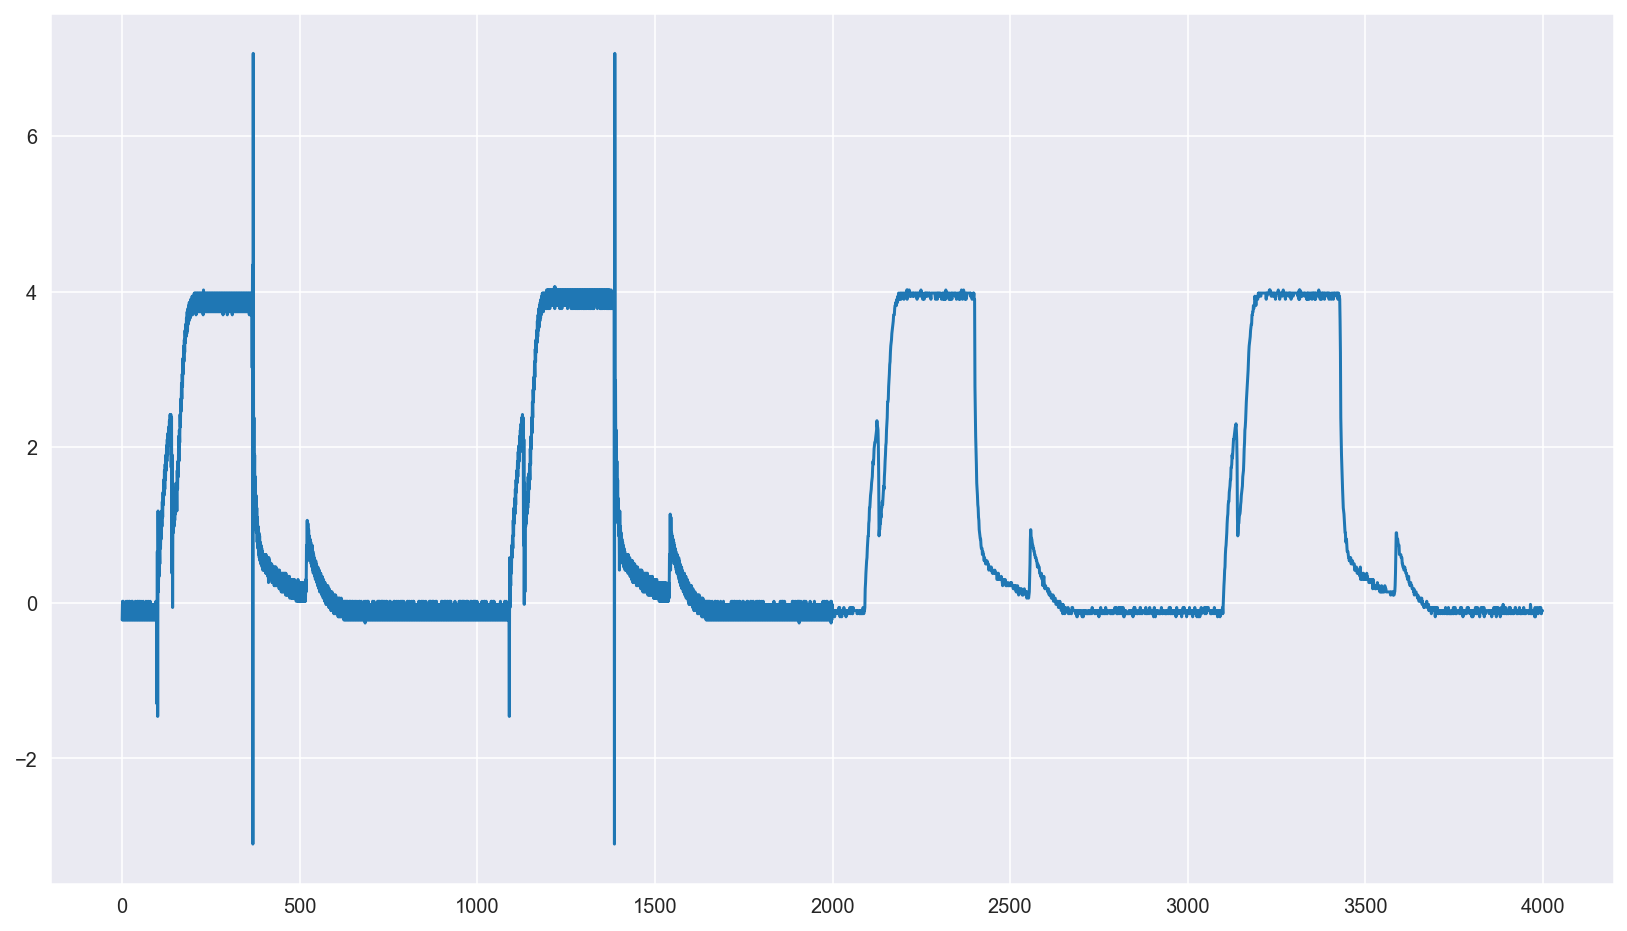

In [14]:
plt.figure(figsize=(14,8))
plt.plot(train_ds['current'].values.reshape(-1,1))

In [15]:
test_ds = build_dataset(testing_files)

In [16]:
test_ds.shape, type(test_ds)

((1000, 2), pandas.core.frame.DataFrame)

In [17]:
def split_sequence(sequence: np.ndarray, window: int, p_window: int) -> Tuple[np.ndarray, np.ndarray]:
    inputs = []
    targets = []

    nb_items = sequence.shape[0]
    max_range = nb_items - window - p_window

    for i in range(max_range):
        x_temp = sequence[i:i + window, :]
        y_temp = sequence[i + window:i + window + p_window, :]
        inputs.append(x_temp)
        targets.append(y_temp)

    return np.array(inputs), np.array(targets)

We are ready to go, but first, let's setup our hyperparameters.

In [18]:
window = 45
p_window = 1
batch_size = 32
learning_rate = 0.001
epochs = 1000

In [19]:
train_x, train_y = split_sequence(train_ds['current'].values.reshape(-1,1), window, p_window)

In [20]:
train_x.shape, train_y.shape

((3954, 45, 1), (3954, 1, 1))

### Loss function

The DeepAnT paper specifies that the best loss function for our neural network is Mean Absolute Error. Keras is mostly geared towards Mean Squared Error, so we need to adjust that. 

In [21]:
model = create_model(window=window, p_window=p_window)
loss_function = keras.losses.MeanAbsoluteError()
model.compile(optimizer='Adam', loss=loss_function, metrics=[metrics.MeanAbsoluteError()])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 43, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 21, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 289       
Total params: 3,521
Trainable params: 3,521
Non-trainable params: 0
______________________________________________________

In [23]:
history = model.fit(train_x, train_y, epochs=epochs, verbose=0)

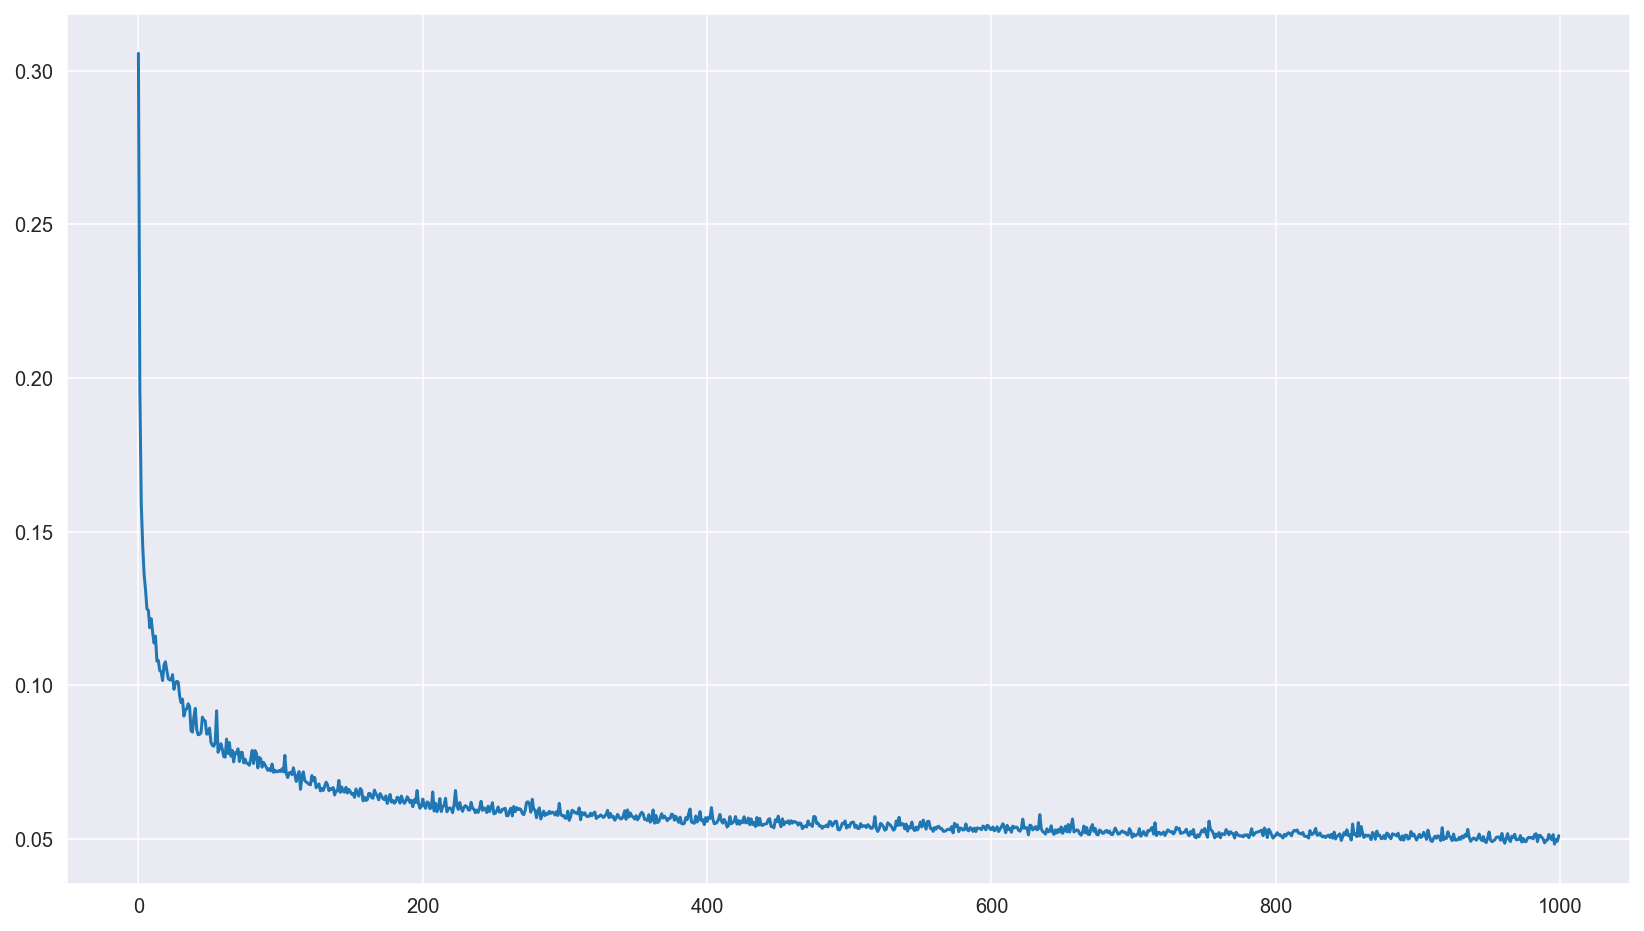

In [24]:
loss = history.history['loss']
plt.figure(figsize=(14,8))
plt.plot(np.array(loss))

In [25]:
test_x, test_y = split_sequence(test_ds['current'].values.reshape(-1,1), window, p_window)

In [26]:
test_x.shape, test_y.shape

((954, 45, 1), (954, 1, 1))

In [27]:
predictions = model.predict(test_x, verbose=1)
predictions.shape

30/30 [==============================] - 0s 626us/step


(954, 1)

## Anomaly predictor

The DeepAnT paper specifies that the anomaly score is the Euclidean distance between the predicted datapoint and the real datapoint. 
If the anomaly score is above a certain threshold then an anomaly is raised. This threshold is domain dependent.

The following function calculates the distance between all the predicted datapoints and their real targets. 

In [28]:
def distance_calculator(model: Sequential, input: np.ndarray, target: np.ndarray) -> np.ndarray:
    distance = []
    prediction = model.predict(input, verbose=0)
    for i in range(input.shape[0]):
        d = np.linalg.norm(prediction[i,:] - target[i,:,:], ord=2)
        distance.append(d)
        
    return np.array(distance)

In [29]:
distance = distance_calculator(model, test_x, test_y)

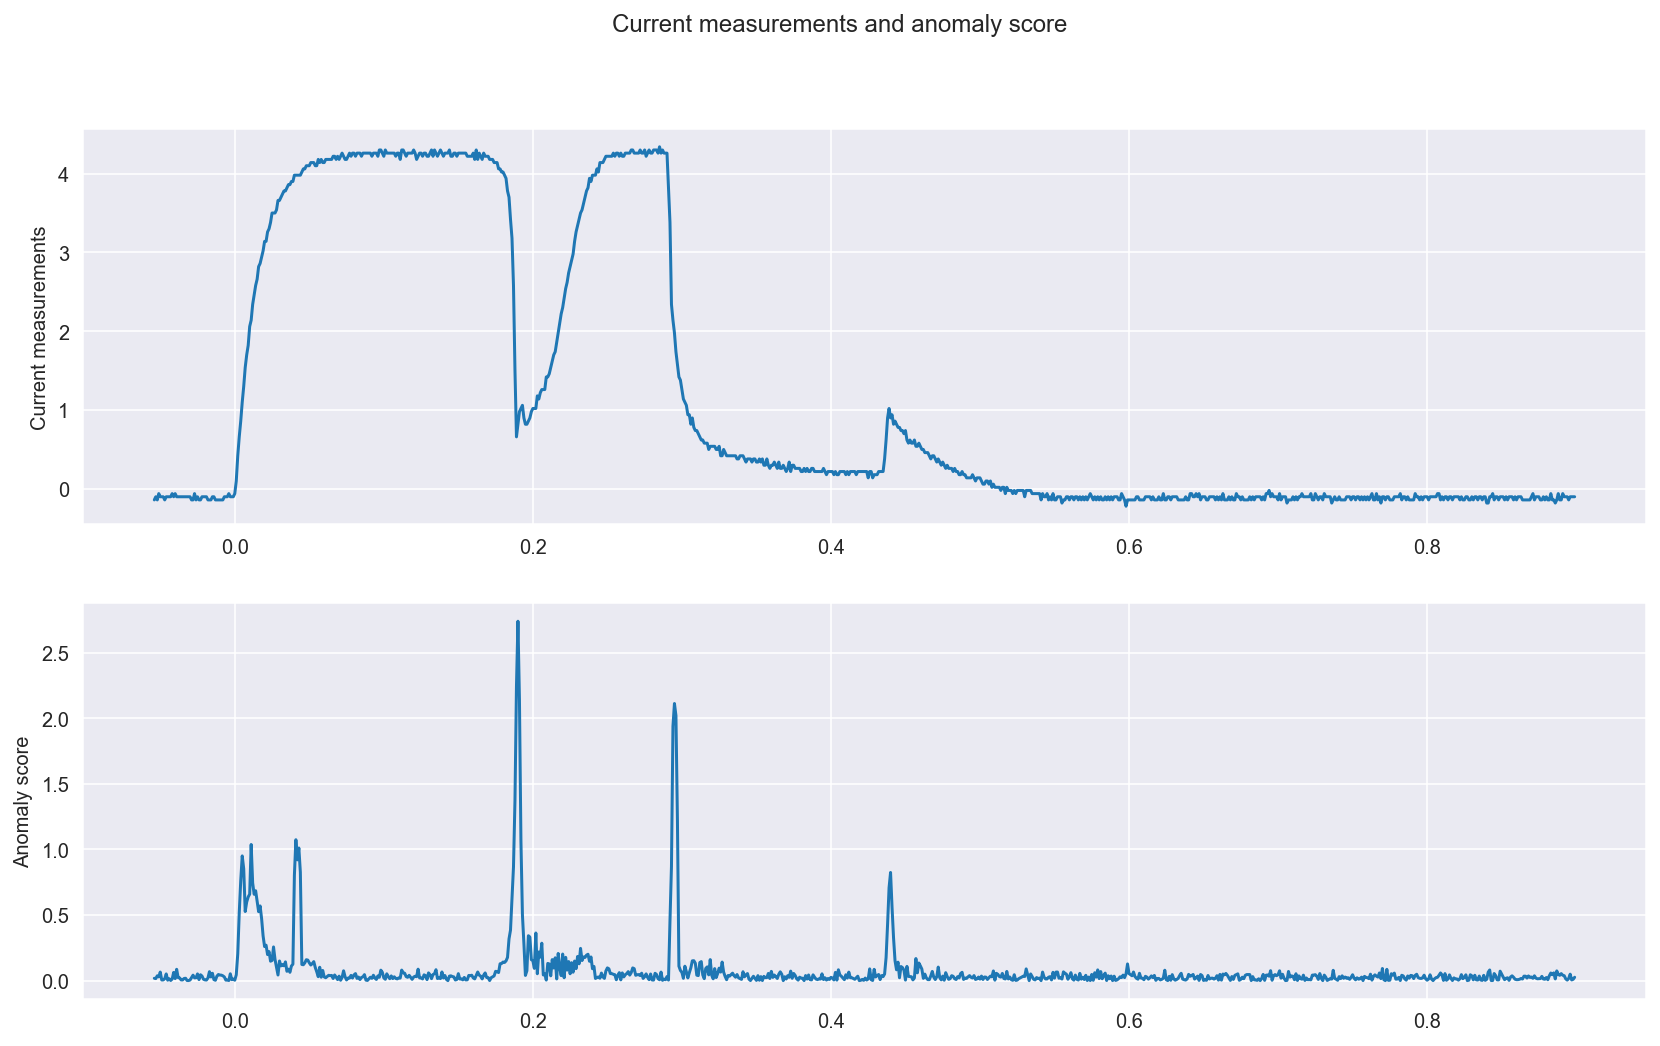

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
fig.suptitle('Current measurements and anomaly score')

ax1.plot(test_ds.iloc[window+p_window:,0], test_ds.iloc[window+p_window:,1], '-')
ax1.set_ylabel('Current measurements')

ax2.plot(test_ds.iloc[window+p_window:,0], distance, '-')
ax2.set_ylabel('Anomaly score')

plt.show()